# 4.5 がんによる死亡

## インポート・設定

In [3]:
import dataclasses
import warnings
from numbers import Number

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from IPython.display import Math
from scipy import stats

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
sns.set_theme()
warnings.simplefilter("ignore")
RANDM_STATE = np.random.default_rng(seed=0)

## a

- データ:
    - 人口(10,000人単位) $X_i$ とがんによる死亡者数 $Y_i$ の組 $(X_i, Y_i)$ 
- モデル:
    - がんの発生率 $\theta$ が与えられたもとで、独立に $Y_i \sim \text{Poisson}(\theta X_i)$ となる
- 事前分布:
    - $\theta \sim \text{Gamma}(a, b)$

データ $\mathcal{D} = (\vec{X}, \vec{Y}) = \{(X_i, Y_i)\}_{i=1 \sim n}$ が与えられたもとでの $\theta$ の事後分布を求める。

事前分布と尤度を書き下すと以下のようになる。

$$
\begin{aligned}
p(\theta) &= \text{dgamma}(\theta, a, b) \\
&= \frac{b^a}{\Gamma(a)} \theta^{a - 1}e^{-b\theta} \\
\end{aligned}
$$

$$
\begin{aligned}
p(\vec{y} | \theta) &= \prod _{i} \text{dpoisson}(y_i , \theta x_i) \\
&= \prod _{i} \frac{(\theta x_i)^{y_i}}{y_i !}e^{-(\theta x_i)} \\
&= \left \{
    \prod _{i} \frac{x_i^{y_i}}{y_i !}
\right \}
\theta ^{\sum_{i} y_i} e^{- \theta \sum_{i} x_i}
\end{aligned}
$$

以上の式から、 $\theta$ の事後分布を計算する。

$$
\begin{aligned}
p(\theta | \mathcal{D}) & \propto p(\vec{y} | \theta) p(\theta) \\
& \propto \theta^{a + \sum_{i} y_i - 1} e^{-(b + \sum_{i}x_i)\theta} \\
& \propto \text{dgamma}\left(\theta, a +  \sum_{i} y_i, b + \sum_{i} x_i \right)
\end{aligned}
$$

よって、事後分布は $\text{Gamma}\left(\theta, a +  \sum_{i} Y_i, b + \sum_{i} X_i \right)$ となることが分かった。

$a$ は「データに含まれるがんによる死亡者数の合計」、 $b$ は「データに含まれる人口の合計」と解釈できる。

## データのダウンロード

In [5]:
urls = {
    "cancer_noreact": "http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/cancer_noreact.dat",
    "cancer_react": "http://www2.stat.duke.edu/~pdh10/FCBS/Exercises/cancer_react.dat",
}
df_cancer_noreact = pd.read_csv(urls["cancer_noreact"], sep="\s+")
df_cancer_react = pd.read_csv(urls["cancer_react"], sep="\s+")

In [6]:
df_cancer_noreact.info()
df_cancer_noreact.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       78 non-null     int64
 1   y       78 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


,x,y
0,3,4
1,11,19
2,5,13
3,10,24
4,5,16


In [7]:
df_cancer_react.info()
df_cancer_react.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   x       10 non-null     int64
 1   y       10 non-null     int64
dtypes: int64(2)
memory usage: 288.0 bytes


,x,y
0,6,15
1,5,16
2,3,12
3,4,6
4,27,77


- データ
    - `cancer_noreact`: ある州の中の原子炉から遠い地域のデータ
        - 死亡率: $\theta_{1} \sim \text{gamma}(a_1, b_1)$ 
    - `cancer_react`: 同じ州の原子炉の近くにある地域のデータ
        - 死亡率: $\theta_{2} \sim \text{gamma}(a_2, b_2)$ 
- カラム
    - `x`: 1990年の人口(10,000人単位)
    - `y`: がんによる死亡者数

## b

$\theta_1, \theta_2$ の事後分布を求める。

前問より、事後分布は以下の形で表せる。

$$
\begin{aligned}
\{\theta | \mathcal{D}\}
\sim 
\text{Gamma}\left(a +  \sum_{i} y_i, b + \sum_{i} x_i \right)
\end{aligned}
$$

それぞれのデータについて、`x`,`y`の和を計算する。

In [8]:
print("cancer_noreact")
display(df_cancer_noreact.sum())

print("cancer_react")
display(df_cancer_react.sum())

cancer_noreact


x    1037
y    2285
dtype: int64

cancer_react


x     95
y    256
dtype: int64

以上の結果から、事後分布は以下のようになる。

$$
\begin{aligned}
\{\theta_{1} | \mathcal{D}\}
&\sim 
\text{Gamma}\left(a_{1} +  2285, b_{1} + 1037 \right)
\\
\{\theta_{2} | \mathcal{D}\}
&\sim 
\text{Gamma}\left(a_{2} +  256, b_{2} + 95 \right)
\end{aligned}
$$

## c

前年のがん発生率は10,000人あたり $\tilde{\theta} = 2.2$ であったと仮定する。

1. 意見1: 
    - $a_1 = a_2 = 2.2 \times 100$
    - $b_1 = b_2 = 100$
    - どちらとも強い信念
2. 意見2: 
    - $a_1  = 2.2 \times 100,~ b_1 = 100$
    - $a_2  = 2.2 ,~ b_1 = 1$
    - 原子炉から遠い地域のがん発生率は強い信念、原子炉に近い地域のがん発生率は弱い信念
3. 意見3: 
    - $a_1 = a_2 = 2.2 $
    - $b_1 = b_2 = 1$
    - どちらとも弱い信念

In [9]:
n_draws = 100_000

In [10]:
@dataclasses.dataclass
class GammaDist:
    """ガンマ分布のパラメータを格納するクラス"""

    a: Number
    b: Number

    @property
    def rv(self):
        return stats.gamma(a=self.a, scale=1 / self.b)

    def sample(self, size) -> np.ndarray:
        return self.rv.rvs(size=size, random_state=RANDM_STATE)

In [38]:
def summarise_result(
    a1,
    b1,
    a2,
    b2,
    df_cancer_noreact,
    df_cancer_react,
):
    """それぞれの意見のに対する事後分布の結果をまとめる"""

    result_dict = {}

    # posterior distributions
    posterior1 = GammaDist(
        a=a1 + df_cancer_noreact["y"].sum(),
        b=b1 + df_cancer_noreact["x"].sum(),
    )
    posterior2 = GammaDist(
        a=a2 + df_cancer_react["y"].sum(),
        b=b2 + df_cancer_react["x"].sum(),
    )
    result_dict["posterior1"] = posterior1
    result_dict["posterior2"] = posterior2

    # posterior mean
    result_dict["mean_theta1"] = np.round(posterior1.rv.stats(moments="m"), 3)
    result_dict["mean_theta2"] = np.round(posterior2.rv.stats(moments="m"), 3)

    # credible interval
    result_dict["ci95_theta1"] = np.round(posterior1.rv.ppf([0.025, 0.975]), 3)
    result_dict["ci95_theta2"] = np.round(posterior2.rv.ppf([0.025, 0.975]), 3)

    # probability of theta2 > theta1
    result_dict["proba"] = np.mean(
        posterior1.sample(n_draws) < posterior2.sample(n_draws)
    )

    return dataclasses.make_dataclass("Results", fields=result_dict.keys())(
        **result_dict
    )


def display_results(results):
    """結果を表形式で表示する"""
    latex = r"""
    \begin{array}{c|c:c:c}
    &E[\theta|data] &\text{0.95 CI} & \text{Pr}(\theta_{2} > \theta_{1} | data) \\
    \hline
    \theta_{1} & %.3f & [%.3f, %.3f] & %.3f  \\
    \theta_{2} & %.3f & [%.3f, %.3f] & -  \\
    \end{array}
    """ % (
        results.mean_theta1,
        *results.ci95_theta1,
        results.proba,
        results.mean_theta2,
        *results.ci95_theta2,
    )
    return Math(latex)

In [12]:
def plot_pdf(
    distribution: stats.rv_continuous,
    lim: tuple,
    label=None,
    ax=None,
    plot_ci: bool = True,
    n_points: int = 300,
):
    """密度関数をプロットする"""

    x = np.linspace(*lim, n_points)
    proba = distribution.pdf(x)
    ax_ = sns.lineplot(
        data={"x": x, "p(x)": proba},
        x="x",
        y="p(x)",
        ax=ax,
        label=label,
        color=sns.color_palette("tab10")[len(ax.lines) if ax else 0],
    )
    if plot_ci:
        ci = distribution.ppf([0.025, 0.975])
        ax_.fill_between(
            x=x,
            y1=proba,
            where=np.logical_and(ci[0] < x, x < ci[1]),
            color=sns.color_palette("pastel")[len(ax_.lines) - 1],
        )
        ax_.vlines(
            x=ci,
            ymin=np.zeros(2),
            ymax=distribution.pdf(ci),
            colors="k",
            linestyles="dashed",
        )
    ax_.set_title("Probability Density Function" + " with 95%CI" if plot_ci else "")
    return ax_


def plot_pdf_comparison(results, lim: tuple):
    ax1 = plot_pdf(results.posterior1.rv, lim=lim, label="theta1")
    ax2 = plot_pdf(results.posterior2.rv, lim=lim, label="theta2", ax=ax1)
    return ax2

### 意見1

In [39]:
results1 = summarise_result(
    a1=2.2 * 100,
    b1=100,
    a2=2.2 * 100,
    b2=100,
    df_cancer_noreact=df_cancer_noreact,
    df_cancer_react=df_cancer_react,
)


display_results(results1)

<IPython.core.display.Math object>

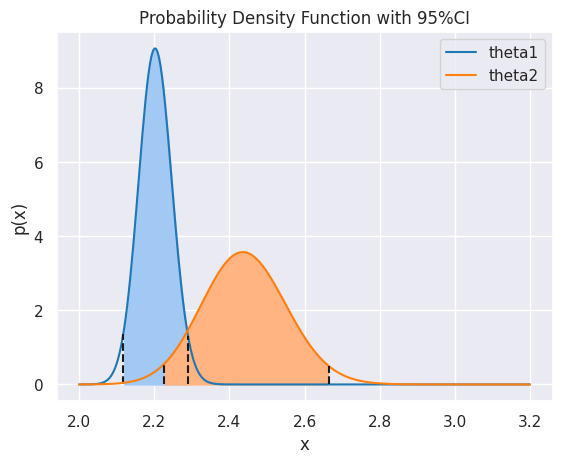

In [14]:
_ = plot_pdf_comparison(results1, lim=(2.0, 3.2))

### 意見2

In [15]:
results2 = summarise_result(
    a1=2.2 * 100,
    b1=100,
    a2=2.2,
    b2=1,
    df_cancer_noreact=df_cancer_noreact,
    df_cancer_react=df_cancer_react,
)


display_results(results2)

<IPython.core.display.Math object>

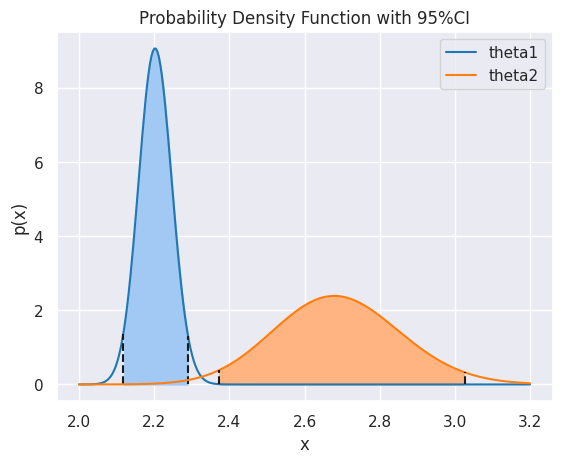

In [16]:
_ = plot_pdf_comparison(results2, lim=(2.0, 3.2))

### 意見3

In [17]:
results3 = summarise_result(
    a1=2.2,
    b1=1,
    a2=2.2,
    b2=1,
    df_cancer_noreact=df_cancer_noreact,
    df_cancer_react=df_cancer_react,
)


display_results(results3)

<IPython.core.display.Math object>

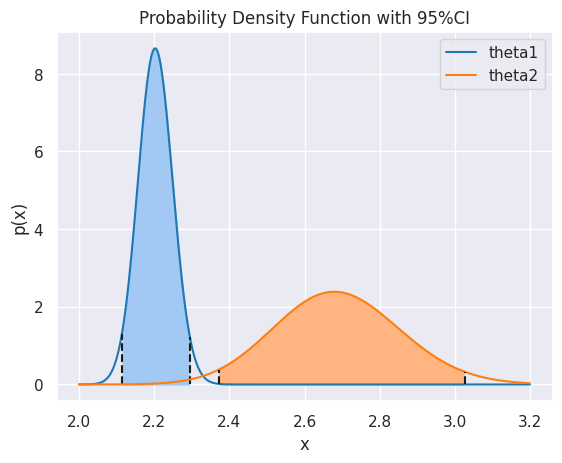

In [18]:
_ = plot_pdf_comparison(results3, lim=(2.0, 3.2))

## d

人口規模が致死率に影響を与える可能性として、以下のことが考えられる。(Claude Chatに聞きました)

1. 医療資源へのアクセス:
    - 大規模な人口を抱える地域では、医療施設や医療従事者数が多く、がん検診や治療へのアクセスが良いため、死亡率が低くなる可能性があります。
2. 環境要因: 
    - 人口密集地域では大気汚染や化学物質曝露のリスクが高く、がん発症リスクが上がる可能性があります。
3. ライフスタイル: 
    - 都市部では運動不足、食生活の西洋化などのライフスタイル要因からがんリスクが高まる傾向にあります。

人口規模が致死率に影響を与える可能性がある場合、モデルを変更する必要がある。例えば以下のようなモデルが考えられる。

$$
\begin{aligned}
& {Y_i | \theta} \sim \text{Poisson}(\theta X_i) \\
& \log(\theta) = \beta _0 + \beta _1 X_i \\ 
& \beta _0 \sim N(\mu _0, \sigma _0^2) \\
& \beta _1 \sim N(\mu _1, \sigma _1^2)
\end{aligned}
$$

## e

今までは、 $\theta_1, \theta_2$ が信念を互いに情報を与えないことを反映して、事前分布を以下のように設定していた。  
事前分布の密度関数が積の形になっていることが「互いに情報を与えないこと」を表している。

$$
p(\theta_1, \theta_2) = 
p(\theta_1) \times p(\theta_2) = 
\text{dgamma}(\theta_1, a_1, b_1)
\times
\text{dgamma}(\theta_2, a_2, b_2)
$$

$\theta_1, \theta_2$ を従属であるように定式化するには、同時事前分布の密度関数が積の形で分解できない分布を選べばいい。  
例えば、[ウィシャート分布](https://en.wikipedia.org/wiki/Wishart_distribution)(カイ二乗分布の多変量版)や
[行列ガンマ分布](https://en.wikipedia.org/wiki/Matrix_gamma_distribution)(ガンマ分布の多変量版)を選べばいい。